In [1]:
import os
import jax
import numpy as np
import jax.numpy as jnp
import jax.random as random
from flax import linen as nn
from flax.training import train_state
from flax.training.checkpoints import save_checkpoint, restore_checkpoint
import optax
import matplotlib.pyplot as plt
from mlp import MLP

In [2]:
train_data = np.load("data/train_data.npy")
train_labels = np.load("data/train_labels.npy")
test_data = np.load("data/test_data.npy")
test_labels = np.load("data/test_labels.npy")

# Convert to jax
train_data = jnp.array(train_data)
train_labels = jnp.array(train_labels)
test_data = jnp.array(test_data)
test_labels = jnp.array(test_labels)

In [3]:
# Create TrainState to Manage Parameters and Optimizer
def create_train_state(rng, model, learning_rate, input_shape):
    params = model.init(rng, jnp.ones(input_shape))  # Initialize parameters
    tx = optax.adam(learning_rate)  # Optimizer
    # L2 regularization
    #tx = optax.adamw(learning_rate, weight_decay=1e-4)
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

# Training Step
@jax.jit
def train_step(state, x, y):
    def loss_fn(params):
        predictions = state.apply_fn(params, x)
        loss = jnp.mean((predictions - y) ** 2) # MSE Loss
        return loss
    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss

@jax.jit
def train_step_reg(state_reg, x, y, alpha=0.00000001):
    def loss_fn_reg(params):
        predictions = state_reg.apply_fn(params, x)
        loss = jnp.mean((predictions - y) ** 2) # MSE Loss
        loss += alpha * jnp.sum(jnp.abs(state_reg.params['params']['Dense_0']['kernel'])) # L1 Regularization
        # keep continuity in the predictions
        #loss += 0.5*jnp.mean((predictions[:-1]-predictions[1:])**2)
        loss += 0.01 * jnp.mean(jnp.abs(predictions[:, 1:] - predictions[:, :-1]))
        return loss
    grad_fn = jax.value_and_grad(loss_fn_reg)
    loss, grads = grad_fn(state_reg.params)
    state_reg = state_reg.apply_gradients(grads=grads)
    return state_reg, loss

# Evaluation Step
@jax.jit
def eval_step(state, x, y):
    predictions = state.apply_fn(state.params, x)
    loss = jnp.mean((predictions - y) ** 2)  # MSE Loss
    return loss

# Main Training Loop
def train_and_evaluate(train_data, train_labels, test_data, test_labels, 
                       depth, num_epochs, batch_size, learning_rate, checkpoint_dir, 
                       reg=False, noise_augmentation=False):
    key = random.PRNGKey(0)
    model = MLP(hidden_sizes=[64, 64])

    # Create TrainState
    input_shape = (batch_size, 5, depth)
    state = create_train_state(key, model, learning_rate, input_shape)

    num_batches = train_data.shape[0] // batch_size
    train_losses, test_losses = [], []
    
    n_half_train = train_data.shape[0]//2

    for epoch in range(num_epochs):
        # Shuffle the data
        perm = random.permutation(key, train_data.shape[0])
        train_data = train_data[perm]
        train_labels = train_labels[perm]
        
        if noise_augmentation:
            # add noise to half of train data to avoid overfitting
            train_data = train_data.at[:n_half_train,0,:].add(random.normal(key, train_data[:n_half_train,0,:].shape) * 0.01)

        # Train
        epoch_loss = 0
        for i in range(num_batches):
            batch_x = train_data[i * batch_size:(i + 1) * batch_size]
            batch_y = train_labels[i * batch_size:(i + 1) * batch_size]
            
            if reg:
                state, loss = train_step_reg(state, batch_x, batch_y)
            else:
                state, loss = train_step(state, batch_x, batch_y)
            epoch_loss += loss

        # Track loss
        epoch_loss /= num_batches
        test_loss = eval_step(state, test_data, test_labels)

        train_losses.append(epoch_loss)
        test_losses.append(test_loss)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}, Train Loss: {epoch_loss:.7f}, Test Loss: {test_loss:.7f}")

    # Save the model
    save_checkpoint(checkpoint_dir, target=state.params, step=num_epochs)
    print(f"Model saved to {checkpoint_dir}.")

    # Plot the losses
    plt.plot(jnp.log(jnp.array(train_losses)), label="Train Loss")
    plt.plot(jnp.log(jnp.array(test_losses)), label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Log Loss")
    plt.legend()
    plt.title("Train and Test Loss")
    plt.savefig(f"loss{num_epochs}.png")
    plt.show()

    return state

In [4]:
depth = train_data.shape[2]  # Assuming input shape (n_sim, 5, depth)
num_epochs = 80
batch_size = 64
learning_rate = 5e-4

Epoch 10, Train Loss: 0.0000091, Test Loss: 0.0000097
Epoch 20, Train Loss: 0.0000045, Test Loss: 0.0000040
Epoch 30, Train Loss: 0.0000037, Test Loss: 0.0000035
Epoch 40, Train Loss: 0.0000030, Test Loss: 0.0000030
Epoch 50, Train Loss: 0.0000027, Test Loss: 0.0000025
Epoch 60, Train Loss: 0.0000025, Test Loss: 0.0000031
Epoch 70, Train Loss: 0.0000025, Test Loss: 0.0000019
Epoch 80, Train Loss: 0.0000022, Test Loss: 0.0000023
Model saved to /home/durifa/Documents/deep_emulators/ige-myself/checkpoints.


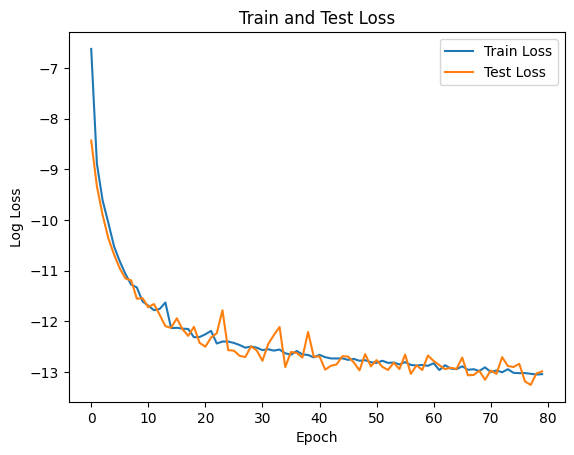

In [5]:
checkpoint_dir = os.path.abspath("checkpoints")

# Assuming train_data, train_labels, test_data, and test_labels are preprocessed and loaded

state = train_and_evaluate(train_data, train_labels, test_data, 
                           test_labels, depth, num_epochs, 
                           batch_size, learning_rate, checkpoint_dir)

In [6]:
# To reload the model
restored_params = restore_checkpoint(checkpoint_dir, target=None)
print("Model parameters restored from 'checkpoints/'.")

Model parameters restored from 'checkpoints/'.


/home/durifa/anaconda3/envs/tunax_env/lib/python3.10/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1136: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


Epoch 10, Train Loss: 0.0000106, Test Loss: 0.0000109
Epoch 20, Train Loss: 0.0000051, Test Loss: 0.0000036
Epoch 30, Train Loss: 0.0000041, Test Loss: 0.0000041
Epoch 40, Train Loss: 0.0000036, Test Loss: 0.0000031
Epoch 50, Train Loss: 0.0000034, Test Loss: 0.0000029
Epoch 60, Train Loss: 0.0000033, Test Loss: 0.0000030
Epoch 70, Train Loss: 0.0000031, Test Loss: 0.0000027
Epoch 80, Train Loss: 0.0000029, Test Loss: 0.0000024
Model saved to /home/durifa/Documents/deep_emulators/ige-myself/checkpoints_noise.


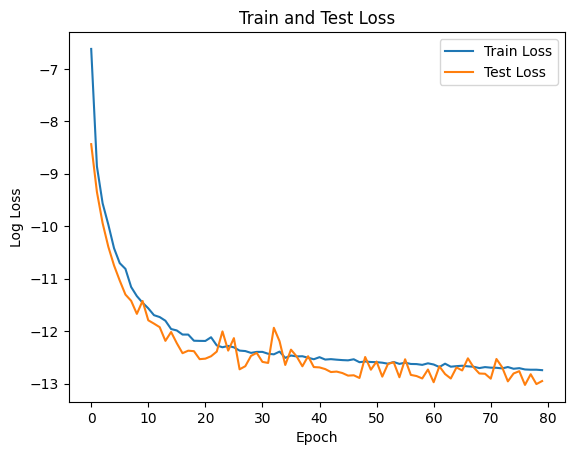

In [7]:
checkpoint_dir_noise = os.path.abspath("checkpoints_noise")

state = train_and_evaluate(train_data, train_labels, test_data, 
                           test_labels, depth, num_epochs, 
                           batch_size, learning_rate, checkpoint_dir_noise, noise_augmentation=True)

Epoch 10, Train Loss: 0.0000602, Test Loss: 0.0000173
Epoch 20, Train Loss: 0.0000423, Test Loss: 0.0000067
Epoch 30, Train Loss: 0.0000381, Test Loss: 0.0000076
Epoch 40, Train Loss: 0.0000323, Test Loss: 0.0000054
Epoch 50, Train Loss: 0.0000288, Test Loss: 0.0000042
Epoch 60, Train Loss: 0.0000256, Test Loss: 0.0000039
Model saved to /home/durifa/Documents/deep_emulators/ige-myself/checkpoints_reg.


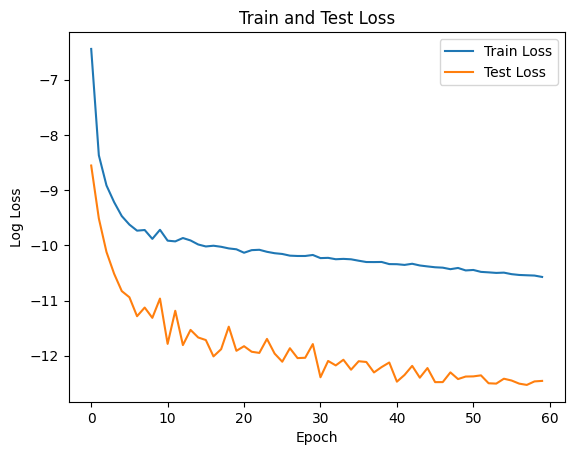

In [8]:
# Test with regularizing loss

checkpoint_dir_reg = os.path.abspath("checkpoints_reg")

state_reg = train_and_evaluate(train_data, train_labels, test_data, 
                           test_labels, depth, 60, 
                           batch_size, learning_rate, checkpoint_dir_reg, reg=True)

In [10]:
import unet

In [ ]:
# model = UNet1D(in_channels=5, out_channels=1)
# variables = model.init(jax.random.PRNGKey(0), jnp.ones((1, 128, 5)))
# output = model.apply(variables, jnp.ones((1, 128, 5)))
# print(output.shape)

In [11]:
# Main Training Loop for UNet1D
def train_and_evaluate_unet(train_data, train_labels, test_data, test_labels, 
                            depth, num_epochs, batch_size, learning_rate, checkpoint_dir, 
                            reg=False, noise_augmentation=False):
    key = random.PRNGKey(0)
    model = unet.UNet1D(in_channels=5, out_channels=1)

    # Create TrainState
    input_shape = (batch_size, 5, depth)
    state = create_train_state(key, model, learning_rate, input_shape)

    num_batches = train_data.shape[0] // batch_size
    train_losses, test_losses = [], []
    
    n_half_train = train_data.shape[0] // 2

    for epoch in range(num_epochs):
        # Shuffle the data
        perm = random.permutation(key, train_data.shape[0])
        train_data = train_data[perm]
        train_labels = train_labels[perm]
        
        if noise_augmentation:
            # add noise to half of train data to avoid overfitting
            train_data = train_data.at[:n_half_train, 0, :].add(random.normal(key, train_data[:n_half_train, 0, :].shape) * 0.01)

        # Train
        epoch_loss = 0
        for i in range(num_batches):
            batch_x = train_data[i * batch_size:(i + 1) * batch_size]
            batch_y = train_labels[i * batch_size:(i + 1) * batch_size]
            
            if reg:
                state, loss = train_step_reg(state, batch_x, batch_y)
            else:
                state, loss = train_step(state, batch_x, batch_y)
            epoch_loss += loss

        # Track loss
        epoch_loss /= num_batches
        test_loss = eval_step(state, test_data, test_labels)

        train_losses.append(epoch_loss)
        test_losses.append(test_loss)

        print(f"Epoch {epoch + 1}, Train Loss: {epoch_loss:.7f}, Test Loss: {test_loss:.7f}")

    # Save the model
    save_checkpoint(checkpoint_dir, target=state.params, step=num_epochs)
    print(f"Model saved to {checkpoint_dir}.")

    # Plot the losses
    plt.plot(jnp.log(jnp.array(train_losses)), label="Train Loss")
    plt.plot(jnp.log(jnp.array(test_losses)), label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Log Loss")
    plt.legend()
    plt.title("Train and Test Loss")
    plt.savefig(f"loss{num_epochs}.png")
    plt.show()

    return state

Epoch 10, Train Loss: 0.0000091, Test Loss: 0.0000097
Epoch 20, Train Loss: 0.0000045, Test Loss: 0.0000040
Epoch 30, Train Loss: 0.0000037, Test Loss: 0.0000035
Epoch 40, Train Loss: 0.0000030, Test Loss: 0.0000030
Epoch 50, Train Loss: 0.0000027, Test Loss: 0.0000025
Epoch 60, Train Loss: 0.0000025, Test Loss: 0.0000031
Epoch 70, Train Loss: 0.0000025, Test Loss: 0.0000019
Epoch 80, Train Loss: 0.0000022, Test Loss: 0.0000023
Model saved to /home/durifa/Documents/deep_emulators/ige-myself/checkpoints_unet.


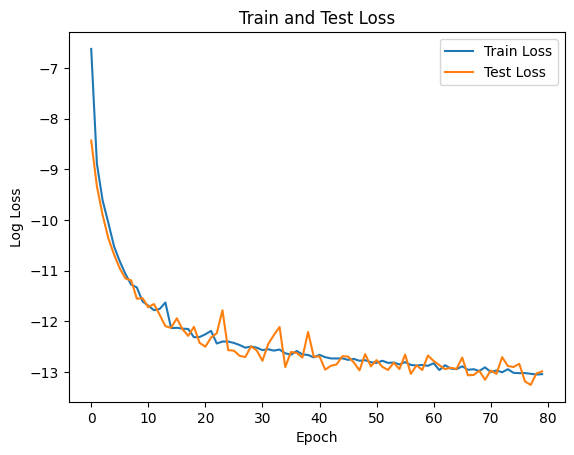

In [12]:
# U-Net

checkpoint_dir_unet = os.path.abspath("checkpoints_unet")

state_reg = train_and_evaluate(train_data, train_labels, test_data,
                           test_labels, 50, 80,
                           64, 5e-4, checkpoint_dir_unet)